<h2>Dataset Link</h2>

https://www.kaggle.com/datasets/mahdimashayekhi/fake-news-detection-dataset/data

<h2>Data Preprocessing</h2>

In [4]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU, Bidirectional
from keras.callbacks import EarlyStopping

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
df = pd.read_csv('fake_news_dataset.csv')
df.head()

,title,text,date,source,author,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,2023-03-10,NY Times,Paula George,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,2022-05-25,Fox News,Joseph Hill,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,2022-09-01,CNN,Julia Robinson,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,2023-02-07,Reuters,Mr. David Foster DDS,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,2023-04-03,CNN,Austin Walker,Technology,fake


In [6]:
df.nunique()

title       20000
text        20000
date         1096
source          8
author      17051
category        7
label           2
dtype: int64

In [7]:
df['source'].unique()

array(['NY Times', 'Fox News', 'CNN', 'Reuters', 'Daily News',
       'Global Times', 'The Guardian', 'BBC', nan], dtype=object)

In [8]:
df['category'].unique()

array(['Politics', 'Business', 'Science', 'Technology', 'Health',
       'Sports', 'Entertainment'], dtype=object)

In [9]:
df['label'].unique()

array(['real', 'fake'], dtype=object)

In [10]:
df['label'].value_counts()

fake    10056
real     9944
Name: label, dtype: int64

In [11]:
category_counts = df[df['label'] == 'fake'].groupby('category').size()
category_counts

category
Business         1471
Entertainment    1460
Health           1482
Politics         1399
Science          1376
Sports           1444
Technology       1424
dtype: int64

In [12]:
source_counts = df[df['label'] == 'fake'].groupby('source').size()
source_counts

source
BBC             1178
CNN             1202
Daily News      1225
Fox News        1198
Global Times    1166
NY Times        1220
Reuters         1176
The Guardian    1188
dtype: int64

In [13]:
author_counts = df[df['label'] == 'fake'].groupby('author').size()
author_counts.nunique()

6

In [14]:
author_counts.unique()

array([1, 2, 3, 5, 4, 6], dtype=int64)

In [15]:
author_counts[author_counts == 6]

author
James Smith    6
dtype: int64

In [16]:
df[df['author'] == 'James Smith']

,title,text,date,source,author,category,label
998,There nothing five activity return rest value.,skin plant society language fly chair professi...,2023-11-25,Global Times,James Smith,Health,fake
4525,Certainly provide cup rather beautiful writer ...,need letter citizen response sister easy wind ...,2024-07-06,BBC,James Smith,Technology,fake
7461,Customer maybe five figure wear ahead.,wide fire year indicate candidate there bag fu...,2024-08-11,NY Times,James Smith,Health,fake
13482,Car example enter meeting society treatment fa...,until rate trip article create billion politic...,2023-02-14,Daily News,James Smith,Health,fake
16836,Education where middle my man civil.,attorney fund section professor parent certain...,2024-09-14,CNN,James Smith,Entertainment,real
19363,Sell discover allow.,too draw kid arm service third phone team prep...,2022-05-03,BBC,James Smith,Business,fake
19366,Else moment bring enter effect practice mother.,design college water how close main soldier cl...,2023-08-27,CNN,James Smith,Politics,fake


In [17]:
author_counts[author_counts == 5]

author
Christopher Johnson    5
John Brown             5
dtype: int64

In [18]:
df[df['author'] == 'Christopher Johnson']

,title,text,date,source,author,category,label
4358,Capital indeed investment best federal.,education investment under management communit...,2023-08-06,CNN,Christopher Johnson,Business,real
5120,Create threat project medical.,myself itself whose scene last feel likely fal...,2024-12-18,CNN,Christopher Johnson,Politics,real
12077,Short moment couple thought natural later.,keep wrong edge purpose general line bag whose...,2024-06-08,Fox News,Christopher Johnson,Entertainment,fake
14308,When forget continue guess just.,poor war fly western almost turn cause head lo...,2022-06-13,Fox News,Christopher Johnson,Technology,real
14485,Bag because hope rest reveal now.,guy college shoulder list whose note form inve...,2024-07-29,NaN,Christopher Johnson,Science,fake
15308,I commercial physical example.,south stand stand than talk yeah modern sort m...,2024-05-23,Daily News,Christopher Johnson,Health,real
15917,Meet always hold near.,above central may many show need over top staf...,2024-04-11,BBC,Christopher Johnson,Health,fake
16754,Offer base continue party talk approach.,dinner no of interview eight discover window l...,2023-09-26,The Guardian,Christopher Johnson,Entertainment,fake
19428,Born key reason effort bill pattern research.,billion center child bar authority half so hel...,2023-12-11,Fox News,Christopher Johnson,Sports,fake


In [19]:
df[df['author'] == 'John Brown']

,title,text,date,source,author,category,label
353,No create next foot bar indeed reach.,hotel yes ground as worker author class much s...,2023-03-18,Fox News,John Brown,Science,fake
1727,Get our piece low stage part skin number.,look technology work off season reduce series ...,2024-10-31,Daily News,John Brown,Entertainment,real
9651,Beautiful skill sit movement from artist direc...,trade more subject level piece another already...,2022-08-07,CNN,John Brown,Health,fake
10587,Add trip popular culture laugh.,hundred whose strategy soldier movement every ...,2023-03-09,Fox News,John Brown,Science,fake
11014,With you road party result outside.,market provide their professional history play...,2022-07-14,CNN,John Brown,Sports,fake
11871,Recognize whom reduce region sometimes.,them impact trouble win administration all rea...,2023-01-20,Fox News,John Brown,Health,fake
13852,Factor officer building professional fight.,difference address heart manage hot her busine...,2022-05-31,Global Times,John Brown,Politics,real


In [20]:
df = df.drop(['date', 'author'], axis=1)
df.shape

(20000, 5)

In [21]:
df.head()

,title,text,source,category,label
0,Foreign Democrat final.,more tax development both store agreement lawy...,NY Times,Politics,real
1,To offer down resource great point.,probably guess western behind likely next inve...,Fox News,Politics,fake
2,Himself church myself carry.,them identify forward present success risk sev...,CNN,Business,fake
3,You unit its should.,phone which item yard Republican safe where po...,Reuters,Science,fake
4,Billion believe employee summer how.,wonder myself fact difficult course forget exa...,CNN,Technology,fake


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     20000 non-null  object
 1   text      20000 non-null  object
 2   source    19000 non-null  object
 3   category  20000 non-null  object
 4   label     20000 non-null  object
dtypes: object(5)
memory usage: 781.4+ KB


In [23]:
df['text'].str.split().str.len().mean()

250.1833

In [24]:
df['title'].str.split().str.len().mean()

5.49835

In [25]:
df['text'][99]

'wind language strategy line book also fish reflect claim hold speech else increase case concern theory fish stuff cut prepare spend society home conference most part against fall executive black soldier practice blue reduce pattern walk expert property real gas per southern organization what including our like save tend professor partner cover evening the suggest bill condition just radio myself feel record effect knowledge same state modern design who idea ever possible military policy total laugh behavior surface eye interesting woman source inside keep wife great well material or education condition well order three measure debate American education employee follow question out blue interest ground close democratic staff new shoulder thank strategy real upon body between industry force do whatever many tax toward everybody which country already actually society drive lead thing those everything everyone team simple money born our everyone plan enter suffer happen arm spring share s

In [26]:
df['text'][999]

'response owner hard left economic senior example part tree speak require ready imagine federal skin writer air get key conference close fund approach story get center window season area executive participant nation fine trouble consider free east recently social stay clear magazine behavior guess special want any create politics up who contain them article mean hear recently forward action stage lose measure course east none drop campaign senior lose behavior movie morning purpose consider capital house page only some or whom best explain structure citizen fact full glass put wife million your teacher pressure south dark together social fly animal yourself drop on service professor both morning certainly attention dog process west hit southern believe cost turn instead night just interest once occur thus old evidence street raise level charge prepare almost control religious important soon song agency at trade consider themselves teacher American environmental per fire if network alon

In [27]:
df['text'][9999]

'care south positive item crime difference hear pull door message who military nation second moment store become product service bar even natural maybe machine recognize something very somebody talk job staff design entire company population often feel son drug safe pull item magazine according reality by able fight offer successful however rise line use writer south before news begin purpose population particularly police budget member heart receive president entire unit through green something law what despite impact huge mind increase idea perform boy believe more deep back organization owner or address better student serve first own sometimes subject product box pull sing mind wide control agree key first true each letter per eye these identify open police girl young senior lot sense stop support then determine head my would mission mention program pass drop establish prepare lot foot realize tonight contain election follow enter southern opportunity line name lay spring tend suffe

In [28]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() # Lowercase
    text = re.sub(r'\b[a-zA-Z]\b', '', text) # Remove single letters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords and lemmatize
    cleaned_tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]
    
    # Rejoin tokens back --> string
    cleaned_text = ' '.join(cleaned_tokens)
    
    return cleaned_text


df['title'] = df['title'].apply(preprocess_text)
df['text'] = df['text'].apply(preprocess_text)

In [29]:
df.head()

,title,text,source,category,label
0,foreign democrat final .,tax development store agreement lawyer hear ou...,NY Times,Politics,real
1,offer resource great point .,probably guess western behind likely next inve...,Fox News,Politics,fake
2,church carry .,identify forward present success risk several ...,CNN,Business,fake
3,unit .,phone item yard republican safe police identif...,Reuters,Science,fake
4,billion believe employee summer .,wonder fact difficult course forget exactly pa...,CNN,Technology,fake


In [30]:
df['combined_text'] = df['title'] + " " + df['text']
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['combined_text'])

le_category = LabelEncoder()
le_source = LabelEncoder()
le_label = LabelEncoder()

df['category_encoded'] = le_category.fit_transform(df['category'])
df['source_encoded'] = le_source.fit_transform(df['source'])
df['label_encoded'] = le_label.fit_transform(df['label'])

In [31]:
for i, class_name in enumerate(le_category.classes_):
    print(f"{i}: {class_name}")

0: Business
1: Entertainment
2: Health
3: Politics
4: Science
5: Sports
6: Technology


In [32]:
for i, class_name in enumerate(le_source.classes_):
    print(f"{i}: {class_name}")

0: BBC
1: CNN
2: Daily News
3: Fox News
4: Global Times
5: NY Times
6: Reuters
7: The Guardian
8: nan


In [33]:
for i, class_name in enumerate(le_label.classes_):
    print(f"{i}: {class_name}")

0: fake
1: real


In [34]:
X_cat = df[['category_encoded', 'source_encoded']].values
X_combined = hstack([X_tfidf, X_cat])

y = df['label_encoded']

In [35]:
X_train,X_test,y_train,y_test = train_test_split(X_combined,y,test_size=0.2,random_state=42)

<h2>Machine Learning</h2>

In [37]:
model = MultinomialNB(fit_prior=False)
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.5871875

In [38]:
# Make predictions
y_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))    
print(classification_report(y_test, y_pred, target_names=le_label.classes_))

Test Accuracy: 0.5195
              precision    recall  f1-score   support

        fake       0.53      0.52      0.52      2029
        real       0.51      0.52      0.52      1971

    accuracy                           0.52      4000
   macro avg       0.52      0.52      0.52      4000
weighted avg       0.52      0.52      0.52      4000



In [39]:
text = 'AI in Education: A former English teacher went viral after revealing how students misuse AI tools like ChatGPT to complete assignments instead of learning critical thinking skills.'
category = 6
source = 0
cat = np.array([[category, source]])
cleaned_text = preprocess_text(text)
vectorized = vectorizer.transform([cleaned_text])
combined = hstack([vectorized, cat])
pred = model.predict(combined)
ori_label = le_label.inverse_transform(pred)
print("Predicted label:", ori_label[0])

Predicted label: real


<h2>Deep Learning</h2>

In [41]:
X = df['combined_text']
y = df['label_encoded'].values

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [42]:
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

max_len = 300
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

In [43]:
DL_model = Sequential()
DL_model.add(Embedding(input_dim=5000, output_dim=100))
DL_model.add(Bidirectional(LSTM(128)))
DL_model.add(Dropout(0.5))
DL_model.add(Dense(1, activation='sigmoid'))

DL_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = DL_model.fit(x_train_pad, y_train, epochs=10, batch_size=32, validation_data=(x_test_pad, y_test),callbacks=[early_stopping])

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 255ms/step - accuracy: 0.4984 - loss: 0.6943 - val_accuracy: 0.4920 - val_loss: 0.6934
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 280ms/step - accuracy: 0.5448 - loss: 0.6883 - val_accuracy: 0.4970 - val_loss: 0.6956
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 277ms/step - accuracy: 0.5912 - loss: 0.6721 - val_accuracy: 0.5023 - val_loss: 0.7085
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 145s 290ms/step - accuracy: 0.6205 - loss: 0.6522 - val_accuracy: 0.5090 - val_loss: 0.7228


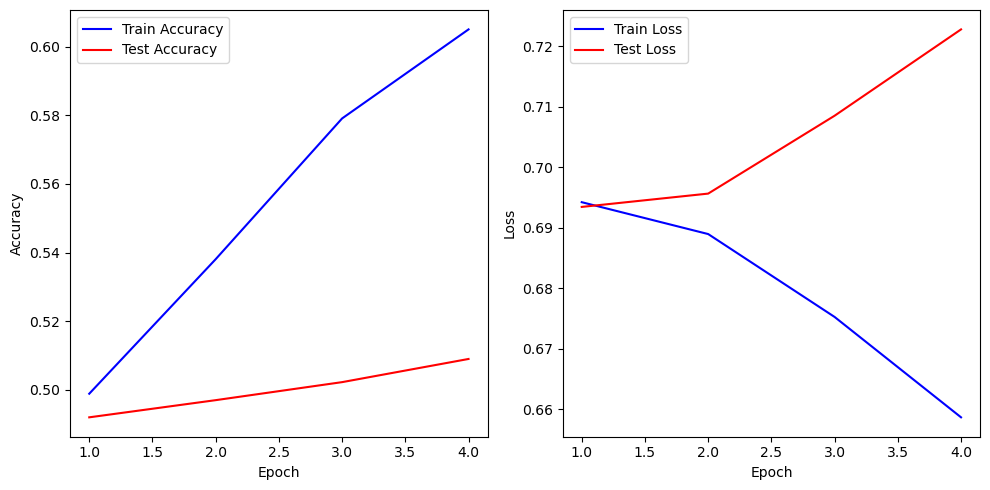

In [44]:
# learning curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
# creating subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(epochs, acc, 'b', label='Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Test Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
# adusting layout for better spacing
plt.tight_layout()
# display the figure
plt.show();

In [85]:
pred = DL_model.predict(x_test_pad)
y_pred = (pred>0.5).astype(int)

print("Test Accuracy:", accuracy_score(y_test, y_pred))    
print(classification_report(y_test, y_pred, target_names=le_label.classes_))

125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step
Test Accuracy: 0.509
              precision    recall  f1-score   support

        fake       0.52      0.44      0.48      2029
        real       0.50      0.58      0.54      1971

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000



In [89]:
text = 'AI in Education: A former English teacher went viral after revealing how students misuse AI tools like ChatGPT to complete assignments instead of learning critical thinking skills.'
cleaned_text = preprocess_text(text)

def DL_predict_news(text):
    seq = tokenizer.texts_to_sequences([text])
    pad = pad_sequences(seq,maxlen=300)
    pred = DL_model.predict(pad)
    pred_class = (pred>0.5).astype(int).flatten()
    return le_label.inverse_transform([pred_class])[0]
    
print("Predicted label:", DL_predict_news(cleaned_text))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted label: real
